## Get adjacency matrix by type

1. query all cell types in the optic lobe, 
2. pick some cell types (eg. >=500 instances)
3. query all-to-all connectivity (i.e., adjacency matrix) within a neuropil
4. plot the adj matrix and compute some stats


### init setup

In [1]:
"""
This cell does the initial project setup.
If you start a new script or notebook, make sure to copy & paste this part.

A script with this code uses the location of the `.env` file as the anchor for
the whole project (= PROJECT_ROOT). Afterwards, code inside the `src` directory
are available for import.
"""
from pathlib import Path
import sys
from dotenv import load_dotenv, find_dotenv
load_dotenv()
PROJECT_ROOT = Path(find_dotenv()).parent
sys.path.append(str(PROJECT_ROOT.joinpath('src')))
print(f"Project root directory: {PROJECT_ROOT}")

Project root directory: /home/loeschef/prj/2022_Janelia_optic-lobe-connectome


In [2]:
import neuprint
print(neuprint.__version__)

0.4.25


In [3]:
from neuprint import fetch_neurons, fetch_synapses,  fetch_adjacencies, connection_table_to_matrix, merge_neuron_properties
from neuprint import NeuronCriteria as NC, SynapseCriteria as SC

# This library wasn't installed before, you might need to rerun library installation
import navis
import navis.interfaces.neuprint as navnp

In [4]:
from utils import olc_client
c = olc_client.connect(verbose=True)

Connected to https://neuprint-cns.janelia.org[cns].
Client: neuprint-python v0.1.0
User: loeschef@janelia.hhmi.org [readwrite]



In [5]:
import plotly.io as pio

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import numpy as np

In [6]:
from neuprint.queries import fetch_all_rois, fetch_roi_hierarchy

# # Show the ROI hierarchy, with primary ROIs marked with '*'
# print(fetch_roi_hierarchy(include_subprimary=True, mark_primary=True, format='text'))

# show primary ROIs
print(fetch_all_rois())

['AL(L)', 'AL(R)', 'AME(L)', 'AME(R)', 'AMMC(L)', 'AMMC(R)', 'AOTU(L)', 'AOTU(R)', 'ATL(L)', 'ATL(R)', 'AVLP(L)', 'AVLP(R)', 'BU(L)', 'BU(R)', 'CA(L)', 'CA(R)', 'CAN(L)', 'CAN(R)', 'CRE(L)', 'CRE(R)', 'EB', 'EPA(L)', 'EPA(R)', 'FB', 'FLA(L)', 'FLA(R)', 'GA(L)', 'GA(R)', 'GNG', 'GOR(L)', 'GOR(R)', 'IB', 'ICL(L)', 'ICL(R)', 'IPS(L)', 'IPS(R)', 'LA(R)', 'LAL(L)', 'LAL(R)', 'LH(L)', 'LH(R)', 'LO(L)', 'LO(R)', 'LOP(L)', 'LOP(R)', 'ME(L)', 'ME(R)', 'NO', 'PB', 'PED(L)', 'PED(R)', 'PLP(L)', 'PLP(R)', 'PRW', 'PVLP(L)', 'PVLP(R)', 'ROB(L)', 'ROB(R)', 'RUB(L)', 'RUB(R)', 'SAD', 'SCL(L)', 'SCL(R)', 'SIP(L)', 'SIP(R)', 'SLP(L)', 'SLP(R)', 'SMP(L)', 'SMP(R)', 'SPS(L)', 'SPS(R)', 'VES(L)', 'VES(R)', 'WED(L)', 'WED(R)', "a'L(L)", "a'L(R)", 'aL(L)', 'aL(R)', "b'L(L)", "b'L(R)", 'bL(L)', 'bL(R)', 'gL(L)', 'gL(R)']


### get all cell types in OL, and some histograms

In [7]:
from queries.completeness import fetch_ol_types, fetch_ol_types_and_instances, fetch_ol_complete
ol_type = fetch_ol_types(client=c)
print(ol_type)
# ol_type_inst = fetch_ol_types_and_instances(client=c)
# ol_comp = fetch_ol_complete(client=c) #long runtime

identified 450 named neuron types
             type  count
0        (VES085)      1
1      5-HTPMPV03      2
2    5thsLNv/LNd1      2
3             Am1      1
4            aMe1      2
..            ...    ...
445           Y12     89
446           Y13     99
447           Y14    104
448            Y3    322
449            Y?      1

[450 rows x 2 columns]


<AxesSubplot: >

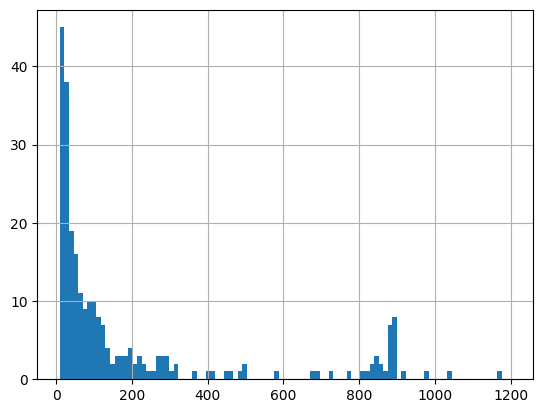

In [8]:
ol_type['count'].hist(bins=np.linspace(10,1200,100))

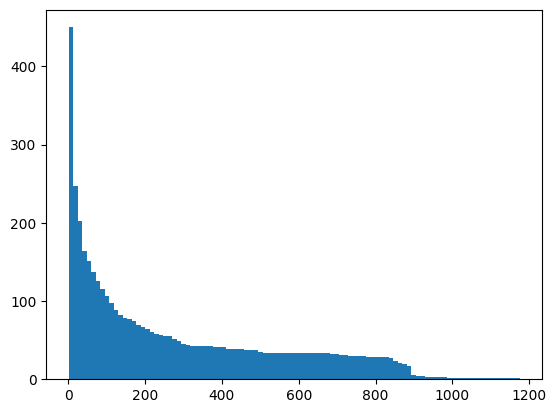

In [9]:
_=plt.hist(ol_type['count'].values, cumulative=-1, bins=100)

### pick some cell types, here >= 500 cells

In [10]:
type_col = ol_type['type'][ol_type['count']>= 500]
cell_types = list(type_col.values)
print(cell_types)

['C2', 'C3', 'Dm2', 'Dm3a', 'L1', 'L2', 'L3', 'L4', 'L5', 'Mi1', 'Mi15', 'Mi4', 'Mi9', 'T1', 'T2', 'T2a', 'T3', 'T4a', 'T4b', 'T4c', 'T4d', 'T5a', 'T5b', 'T5c', 'T5d', 'Tm1', 'Tm2', 'Tm20', 'Tm3', 'Tm4', 'Tm6/14', 'Tm9', 'TmY18', 'TmY5a']


In [11]:
# NOT run, fectch cells
# ctype = ['T4a']
# neu_df, roi_df = fetch_neurons(NC(type=ctype))

### get connectivity and construct adj matrix for plotting

In [12]:
# syn_rois = ['ME(R)', 'LO(R)', 'LOP(R)']
syn_rois = ['LO(R)']
neuron_types_rois_df, conn_types_rois_df = fetch_adjacencies(NC(type=cell_types), NC(type=cell_types), rois=syn_rois, batch_size=1000)

# neuron_types_rois_df, conn_types_rois_df = fetch_adjacencies(NC(type=cell_types), NC(type=cell_types))

  0%|          | 0/14 [00:00<?, ?it/s]

In [13]:
# # save and load csv
# base_dir = PROJECT_ROOT / 'results' / 'connectivity'

# neuron_types_rois_df.to_csv(base_dir / 'neuron_types_rois_df.csv')
# conn_types_rois_df.to_csv(base_dir / 'conn_types_rois_df.csv')

# neuron_types_rois_df= pd.read_csv(base_dir / 'neuron_types_rois_df.csv')
# conn_types_rois_df= pd.read_csv(base_dir / 'conn_types_rois_df.csv')

In [14]:
conn_df = merge_neuron_properties(neuron_types_rois_df, conn_types_rois_df, 'type')
conn_matrix = connection_table_to_matrix(conn_df,'type')
conn_matrix = conn_matrix.rename_axis('type_pre', axis=0).rename_axis('type_post', axis=1)
conn_matrix = conn_matrix.loc[sorted(conn_matrix.index), sorted(conn_matrix.columns)]

/home/loeschef/lib/python/ol-connectome/lib/python3.10/site-packages/neuprint/utils.py:304: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  matrix = agg_weights_df.pivot(col_pre, col_post, weight_col)


In [15]:
# plot adjacency matrix
pd.set_option('display.max_columns', 100)
conn_matrix

type_post,Mi1,Mi15,T2,T2a,T3,T4a,T4b,T4c,T4d,T5a,T5b,T5c,T5d,Tm1,Tm2,Tm20,Tm3,Tm4,Tm6/14,Tm9,TmY18,TmY5a
type_pre,,,,,,,,,,,,,,,,,,,,,,
Mi1,0,0,2,1,1,0,0,0,1,0,0,0,2,4,0,1,0,0,1,0,1,1
Mi15,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T2,6,1,14004,275,564,6,3,10,5,30,38,48,34,10,27,182,265,196,150,18,270,12283
T2a,0,0,120,4654,607,0,1,0,1,4,1,4,1,1,1,92,1042,520,492,7,142,590
T3,0,0,952,940,1375,0,0,3,0,2,3,3,3,3,0,82,1254,1347,6186,6,898,1611
T4a,0,0,13,4,0,47,7,5,2,72,5,1,3,3,1,1,7,3,1,4,2,6
T4b,0,0,1,3,1,8,84,8,4,1,68,3,4,1,7,2,12,10,4,2,4,17
T4c,0,0,7,40,6,14,8,60,4,2,3,11,3,9,6,18,20,13,3,6,4,13
T4d,0,0,22,3,1,9,0,7,11,1,0,1,1,0,7,3,40,0,0,1,5,13


In [16]:
# who's in this matirx 
ol_type[ol_type['type'].isin( list(conn_matrix.index) )]

,type,count
268,Mi1,888
272,Mi15,582
375,T2,823
376,T2a,918
377,T3,981
378,T4a,849
379,T4b,846
380,T4c,883
381,T4d,860
383,T5a,838
